### Import Required Libraries

In [1]:
#Import Required Libraries
import numpy as np # for efficient numerical computations
import pandas as pd # for data management
import matplotlib.pyplot as plt #to customize visualizations
import seaborn as sns #for easy/common visualizations

#Importing sklearn libraries
from sklearn.model_selection import cross_val_score
from sklearn.cross_validation import StratifiedKFold
from sklearn import cross_validation
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn import linear_model
from sklearn import tree
from sklearn import svm
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingRegressor

#Importing xgboost
from xgboost import XGBRegressor

import warnings
warnings.simplefilter("ignore")

#Importing other required libraries
import os
import re
import csv
import operator
import random
import datetime
from datetime import datetime
import warnings
color = sns.color_palette()
%matplotlib inline

random.seed(47)
print'--------------------------------------------------'

--------------------------------------------------


/Users/ram/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Benchmark Model

In [2]:
#Reading Training Data
dftrain = pd.read_csv('train_2016_v2.csv')
dfprop = pd.read_csv('properties_2016.csv')

#Filling missing values with -1
dfprop.fillna(-1,inplace=True)

#Merging Datafiles
df = pd.merge(dftrain, dfprop, on='parcelid', suffixes=('', '_r'))

#Dropping meta columns and casting to accepted dtypes
X = df.drop(['parcelid', 'logerror', 'transactiondate',
             'propertyzoningdesc', 'propertycountylandusecode'], axis=1)
for c in ['hashottuborspa', 'fireplaceflag', 'taxdelinquencyflag']:
    X[c] = X[c].astype('bool')
    
#Applying RandomForestRegressor  
clf = RandomForestRegressor()
scores = cross_validation.cross_val_score(clf, X, df.logerror, cv=10, scoring='neg_mean_absolute_error')
print("%s Accuracy: %0.5f" % (clf.__class__.__name__, scores.mean()))
print'--------------------------------------------------'

RandomForestRegressor Accuracy: -0.08261
--------------------------------------------------


### Data Preprocessing

In [3]:
#Reading Training Data
train = pd.read_csv('train_2016_v2.csv', parse_dates=["transactiondate"])
print ("Shape Of Train: ",train.shape)
train.head()

#Reading Properties Data
prop = pd.read_csv("properties_2016.csv")
print ("Shape Of Train: ",prop.shape)
prop.head()

#Merging both files to create the train file
train = pd.merge(train, prop, on='parcelid', how='left')
print ("Shape Of Train: ",train.shape)
train.head()

#New Variable - Exploring number of transactions in each month
train['New_transaction_month'] = train['transactiondate'].dt.month

#Dropping Columns who's %age of NaN values is greater than 70%
for col in list(train.columns.values):
    nanValues = float(train[col].isnull().sum()) / len(train)
    if nanValues > 0.70:
        #print col
        train = train.drop([col], axis=1)
        
#Corelation Analysis, dropping highly correlated variables")
for col in ('calculatedbathnbr','fullbathcnt','finishedsquarefeet12','rawcensustractandblock','censustractandblock','landtaxvaluedollarcnt','taxvaluedollarcnt'):
    train = train.drop([col], axis=1)
    
#fill median for numeric null columns
for c in train.dtypes[train.dtypes == 'float64'].index.values:
    train[c].fillna(train[c].median(), inplace = True)
    
#Imputing Null values with -1 and encoding Objects
for c in train.columns:
    train[c]=train[c].fillna(-1)
    if train[c].dtype == object:
        lbl = LabelEncoder()
        lbl.fit(list(train[c].values))
        train[c] = lbl.transform(list(train[c].values))
         
#Dropping out outliers
train=train[ train.logerror > -0.417 ]
train=train[ train.logerror < 0.418 ]

#Processing data
for c, dtype in zip(train.columns, train.dtypes):
    if dtype == np.float64:
        train[c] = train[c].astype(np.float32)

#Splitting logerror as test data
test = train.logerror

#Dropping meta columns and casting to accepted dtypes
train = train.drop(['parcelid', 'logerror', 'transactiondate',
                'propertyzoningdesc', 'propertycountylandusecode'], axis=1)   
print'--------------------------------------------------'

('Shape Of Train: ', (90275, 3))
('Shape Of Train: ', (2985217, 58))
('Shape Of Train: ', (90275, 60))
--------------------------------------------------


### Feature Engineering

In [4]:
#Adding new features

#proportion of living area
train['New_LivingAreaProp'] = train['calculatedfinishedsquarefeet']/train['lotsizesquarefeet']

#Number of properties in the zip
zip_count = train['regionidzip'].value_counts().to_dict()
train['New_zip_count'] = train['regionidzip'].map(zip_count)

#Number of properties in the city
city_count = train['regionidcity'].value_counts().to_dict()
train['New_city_count'] = train['regionidcity'].map(city_count)
print'--------------------------------------------------'

--------------------------------------------------


### Model Selection

In [5]:
#Printing out all the Variables
dtype_df = train.dtypes.reset_index()
dtype_df.columns = ["Count", "Column Type"]
print dtype_df

#Testing various Regression models
allModels = {} # Dictionary of models and their respective losses

print("Running XGB Regression")
model = XGBRegressor()
predicted = cross_val_score(model, train, test, scoring='neg_mean_absolute_error', cv=10)
allModels[model] = predicted.mean()

print("Running Linear Regression")
model = linear_model.LinearRegression()
predicted = cross_val_score(model, train, test, scoring='neg_mean_absolute_error', cv=10)
allModels[model] = predicted.mean()

print("Running Bayesian Ridge Regression")
model = linear_model.BayesianRidge()
predicted = cross_val_score(model, train, test, scoring='neg_mean_absolute_error', cv=10)
allModels[model] = predicted.mean()

print("Running Ridge Regression")
model = linear_model.Ridge()
predicted = cross_val_score(model, train, test, scoring='neg_mean_absolute_error', cv=10)
allModels[model] = predicted.mean()

print("Running Lasso Regression")
model = linear_model.Lasso()
predicted = cross_val_score(model, train, test, scoring='neg_mean_absolute_error', cv=10)
allModels[model] = predicted.mean()

print("Running Decision Trees")
model = tree.DecisionTreeRegressor()
predicted = cross_val_score(model, train, test, scoring='neg_mean_absolute_error', cv=10)
allModels[model] = predicted.mean()

print("Running Random Forest")
model = RandomForestRegressor()
predicted = cross_val_score(model, train, test, scoring='neg_mean_absolute_error', cv=10)
allModels[model] = predicted.mean()

print("Running KNN")
model = KNeighborsRegressor()
predicted = cross_val_score(model, train, test, scoring='neg_mean_absolute_error', cv=10)
allModels[model] = predicted.mean()

print("Running Gradient Boosted Regressor")
model = GradientBoostingRegressor()
predicted = cross_val_score(model, train, test, scoring='neg_mean_absolute_error', cv=10)
allModels[model] = predicted.mean()

print("Returning the best model")
sortedModels = sorted(allModels.items(), key=operator.itemgetter(1), reverse=True)
for model in sortedModels:
    print 'Model:', model[0]
    print 'Loss:', model[1]
print'--------------------------------------------------'    

                           Count Column Type
0          airconditioningtypeid     float32
1                    bathroomcnt     float32
2                     bedroomcnt     float32
3          buildingqualitytypeid     float32
4   calculatedfinishedsquarefeet     float32
5                           fips     float32
6                   garagecarcnt     float32
7                garagetotalsqft     float32
8          heatingorsystemtypeid     float32
9                       latitude     float32
10                     longitude     float32
11             lotsizesquarefeet     float32
12         propertylandusetypeid     float32
13                  regionidcity     float32
14                regionidcounty     float32
15          regionidneighborhood     float32
16                   regionidzip     float32
17                       roomcnt     float32
18                       unitcnt     float32
19                     yearbuilt     float32
20    structuretaxvaluedollarcnt     float32
21        

### Model Tuning - GridSearchCV

In [6]:
print("Running Parameter optimization on the Best Model")

params = {  
            "n_estimators": [10,100,200,1000],
            "max_depth": [3,5,7],
            "min_child_weight": [1,3,5]
         }

xgb_model = XGBRegressor()  
xgb_cv    = GridSearchCV(xgb_model,params,verbose = 10,scoring='neg_mean_absolute_error')
xgb_cv.fit(train, test)  

print 'Best Score-', xgb_cv.best_score_
print 'Best Parameters-', xgb_cv.best_params_
print 'Best Estimator-', xgb_cv.best_estimator_
print'--------------------------------------------------'

Running Parameter optimization on the Best Model
Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] n_estimators=10, max_depth=3, min_child_weight=1 ................
[CV]  n_estimators=10, max_depth=3, min_child_weight=1, score=-0.177955210209, total=   1.2s
[CV] n_estimators=10, max_depth=3, min_child_weight=1 ................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s remaining:    0.0s


[CV]  n_estimators=10, max_depth=3, min_child_weight=1, score=-0.179902642965, total=   0.9s
[CV] n_estimators=10, max_depth=3, min_child_weight=1 ................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.3s remaining:    0.0s


[CV]  n_estimators=10, max_depth=3, min_child_weight=1, score=-0.172834858298, total=   0.9s
[CV] n_estimators=100, max_depth=3, min_child_weight=1 ...............


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    3.3s remaining:    0.0s


[CV]  n_estimators=100, max_depth=3, min_child_weight=1, score=-0.0549953505397, total=   8.2s
[CV] n_estimators=100, max_depth=3, min_child_weight=1 ...............


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   11.7s remaining:    0.0s


[CV]  n_estimators=100, max_depth=3, min_child_weight=1, score=-0.052607614547, total=   8.5s
[CV] n_estimators=100, max_depth=3, min_child_weight=1 ...............


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   20.3s remaining:    0.0s


[CV]  n_estimators=100, max_depth=3, min_child_weight=1, score=-0.0519334338605, total=   8.2s
[CV] n_estimators=200, max_depth=3, min_child_weight=1 ...............


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   28.7s remaining:    0.0s


[CV]  n_estimators=200, max_depth=3, min_child_weight=1, score=-0.055236492306, total=  16.3s
[CV] n_estimators=200, max_depth=3, min_child_weight=1 ...............


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   45.4s remaining:    0.0s


[CV]  n_estimators=200, max_depth=3, min_child_weight=1, score=-0.0526209697127, total=  16.2s
[CV] n_estimators=200, max_depth=3, min_child_weight=1 ...............


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  1.0min remaining:    0.0s


[CV]  n_estimators=200, max_depth=3, min_child_weight=1, score=-0.0532585866749, total=  16.4s
[CV] n_estimators=1000, max_depth=3, min_child_weight=1 ..............


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  1.3min remaining:    0.0s


[CV]  n_estimators=1000, max_depth=3, min_child_weight=1, score=-0.0565119758248, total= 1.3min
[CV] n_estimators=1000, max_depth=3, min_child_weight=1 ..............
[CV]  n_estimators=1000, max_depth=3, min_child_weight=1, score=-0.0529724992812, total= 1.3min
[CV] n_estimators=1000, max_depth=3, min_child_weight=1 ..............
[CV]  n_estimators=1000, max_depth=3, min_child_weight=1, score=-0.0565079860389, total= 1.4min
[CV] n_estimators=10, max_depth=3, min_child_weight=3 ................
[CV]  n_estimators=10, max_depth=3, min_child_weight=3, score=-0.17781957984, total=   0.9s
[CV] n_estimators=10, max_depth=3, min_child_weight=3 ................
[CV]  n_estimators=10, max_depth=3, min_child_weight=3, score=-0.179844483733, total=   0.9s
[CV] n_estimators=10, max_depth=3, min_child_weight=3 ................
[CV]  n_estimators=10, max_depth=3, min_child_weight=3, score=-0.172812178731, total=   0.9s
[CV] n_estimators=100, max_depth=3, min_child_weight=3 ...............
[CV]  n_

[CV]  n_estimators=1000, max_depth=5, min_child_weight=3, score=-0.0643947273493, total= 2.2min
[CV] n_estimators=10, max_depth=5, min_child_weight=5 ................
[CV]  n_estimators=10, max_depth=5, min_child_weight=5, score=-0.177612781525, total=   1.5s
[CV] n_estimators=10, max_depth=5, min_child_weight=5 ................
[CV]  n_estimators=10, max_depth=5, min_child_weight=5, score=-0.179691776633, total=   1.5s
[CV] n_estimators=10, max_depth=5, min_child_weight=5 ................
[CV]  n_estimators=10, max_depth=5, min_child_weight=5, score=-0.172898605466, total=   1.4s
[CV] n_estimators=100, max_depth=5, min_child_weight=5 ...............
[CV]  n_estimators=100, max_depth=5, min_child_weight=5, score=-0.055146202445, total=  13.7s
[CV] n_estimators=100, max_depth=5, min_child_weight=5 ...............
[CV]  n_estimators=100, max_depth=5, min_child_weight=5, score=-0.0526128932834, total=  13.3s
[CV] n_estimators=100, max_depth=5, min_child_weight=5 ...............
[CV]  n_es

[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed: 80.3min finished


Best Score- -0.053170955805
Best Parameters- {'n_estimators': 100, 'max_depth': 3, 'min_child_weight': 5}
Best Estimator- XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=5, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)
--------------------------------------------------


### Cross Validation and Feature Importances

Cross validation again using best estimated parameters
Printing Final Score
MAE: 0.05 (+/- 0.00)
Printing Feature Importances
[ 0.          0.02635432  0.0102489   0.          0.10395315  0.
  0.00292826  0.02342606  0.00732064  0.07906296  0.07467057  0.04831625
  0.02342606  0.02342606  0.          0.0204978   0.04245974  0.00292826
  0.0204978   0.07906296  0.09809663  0.          0.13762811  0.0658858
  0.04392387  0.03221083  0.03367496]


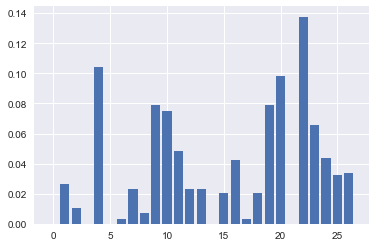

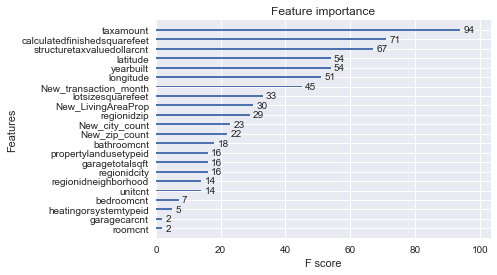

--------------------------------------------------


In [7]:
#Importing xgboost
from xgboost import XGBRegressor
from xgboost import plot_importance

print("Cross validation again using best estimated parameters")
clf = XGBRegressor(learning_rate =0.1,max_depth= 3,min_child_weight=1,n_estimators=100)
scores = cross_validation.cross_val_score(clf, train, test, cv=10,  scoring='neg_mean_absolute_error')
print("Printing Final Score")
print("MAE: %0.2f (+/- %0.2f)" % (abs(scores.mean()), scores.std()*2))

clf.fit(train, test)  
print("Printing Feature Importances")
print clf.feature_importances_
plt.bar(range(len(clf.feature_importances_)),clf.feature_importances_)
plt.show()

plot_importance(clf)
plt.show()
print'--------------------------------------------------'